# Introduction

This tutorial is designed to help you start using uproot. Unlike the [reference documentation](https://uproot.readthedocs.io/en/latest/), which defines every parameter of every function, this tutorial provides introductory examples to help you learn how to use them.

The original tutorial [has been archived](https://github.com/scikit-hep/uproot/blob/master/docs/old-tutorial.rst)—this version was written in June 2019 in response to feedback from a series of tutorials I presented early this year and common questions in the [GitHub issues](https://github.com/scikit-hep/uproot/issues). The new tutorial is [executable on Binder](https://mybinder.org/v2/gh/scikit-hep/uproot/master?urlpath=lab/tree/binder%2Ftutorial.ipynb) and may be read in any order, though it has to be executed from top to bottom because some variables are reused.

# What is uproot?

Uproot is a Python package; it is pip and conda-installable, and it only depends on other Python packages. Although it is similar in function to [root_numpy](https://pypi.org/project/root-numpy/) and [root_pandas](https://pypi.org/project/root_pandas/), it does not compile into ROOT and therefore avoids issues in which the version used in compilation differs from the version encountered at runtime.

In short, you should never see a segmentation fault.

<center><img src="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/abstraction-layers.png" width="75%"></center>

Uproot is strictly concerned with file I/O only—all other functionality is handled by other libraries:

   * [uproot-methods](https://github.com/scikit-hep/uproot-methods): physics methods for types read from ROOT files, such as histograms and Lorentz vectors. It is intended to be largely user-contributed (and is).
   * [awkward-array](https://github.com/scikit-hep/awkward-array): array manipulation beyond [Numpy](https://docs.scipy.org/doc/numpy/reference/). Several are encountered in this tutorial, particularly lazy arrays and jagged arrays.

In the past year, uproot has become one of the most widely used Python packages made for particle physics, with users in all four LHC experiments, theory, neutrino experiments, XENON-nT (dark matter direct detection), MAGIC (gamma ray astronomy), and IceCube (neutrino astronomy).

<center><img src="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/all_file_project.png" width="75%"></center>

# Exploring a file

[uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) is the entry point for reading a single file.

It takes a local filename path or a remote `http://` or `root://` URL. (HTTP requires the Python [requests](https://pypi.org/project/requests/) library and XRootD requires [pyxrootd](http://xrootd.org/), both of which have to be explicitly pip-installed if you installed uproot with pip, but are automatically installed if you installed uproot with conda.)

In [10]:
import uproot

file = uproot.open("https://scikit-hep.org/uproot/examples/nesteddirs.root")
file

<ROOTDirectory b'tests/nesteddirs.root' at 0x7f9a52b6d760>

[uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) returns a [ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory), which behaves like a Python dict; it has `keys()`, `values()`, and key-value access with square brackets.

In [11]:
file.keys()

[b'one;1', b'three;1']

In [12]:
file["one"]

<ROOTDirectory b'one' at 0x7f9a52b6d7f0>

Subdirectories also have type [ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory), so they behave like Python dicts, too.

In [13]:
file["one"].keys()

[b'two;1', b'tree;1']

In [14]:
file["one"].values()

[<ROOTDirectory b'two' at 0x7f9a52adc820>, <TTree b'tree' at 0x7f9a52b6d460>]

**What's the `b` before each object name?** Python 3 distinguishes between bytestrings and encoded strings. ROOT object names have no encoding, such as Latin-1 or Unicode, so uproot presents them as raw bytestrings. However, if you enter a Python string (no `b`) and it matches an object name (interpreted as plain ASCII), it will count as a match, as `"one"` does above.

**What's the `;1` after each object name?** ROOT objects are versioned with a "cycle number." If multiple objects are written to the ROOT file with the same name, they will have different cycle numbers, with the largest value being last. If you don't specify a cycle number, you'll get the latest one.

This file is deeply nested, so while you could find the TTree with

In [15]:
file["one"]["two"]["tree"]

<TTree b'tree' at 0x7f9a52adcca0>

you can also find it using a directory path, with slashes.

In [16]:
file["one/two/tree"]

<TTree b'tree' at 0x7f9a52a3de20>

Here are a few more tricks for finding your way around a file:

   * the `keys()`, `values()`, and `items()` methods have `allkeys()`, `allvalues()`, `allitems()` variants that recursively search through all subdirectories;
   * all of these functions can be filtered by name or class: see [ROOTDirectory.keys](https://uproot.readthedocs.io/en/latest/root-io.html#uproot.rootio.ROOTDirectory.keys).

Here's how you would search the subdirectories to find all TTrees:

In [17]:
file.allkeys(filterclass=lambda cls: issubclass(cls, uproot.tree.TTreeMethods))

[b'one/two/tree;1', b'one/tree;1', b'three/tree;1']

Or get a Python dict of them:

In [18]:
all_ttrees = dict(file.allitems(filterclass=lambda cls: issubclass(cls, uproot.tree.TTreeMethods)))
all_ttrees

{b'one/two/tree;1': <TTree b'tree' at 0x7f9a52a4df10>,
 b'one/tree;1': <TTree b'tree' at 0x7f9a52b6dee0>,
 b'three/tree;1': <TTree b'tree' at 0x7f9a52b4c700>}

Be careful: Python 3 is not as forgiving about matching key names. `all_ttrees` is a plain Python dict, so the key must be a bytestring and must include the cycle number.

In [19]:
all_ttrees[b"one/two/tree;1"]

<TTree b'tree' at 0x7f9a52a4df10>

## Compressed objects in ROOT files

Objects in ROOT files can be uncompressed, compressed with ZLIB, compressed with LZMA, or compressed with LZ4. Uproot picks the right decompressor and gives you the objects transparently: you don't have to specify anything. However, if an object is compressed with LZ4 and you don't have the [lz4](https://pypi.org/project/lz4/) library installed, you'll get an error with installation instructions in the message. (It is automatically installed if you installed uproot with conda.) ZLIB is part of the Python Standard Library, and LZMA is part of the Python 3 Standard Library, so you won't get error messages about these except for LZMA in Python 2 (for which there is [backports.lzma](https://pypi.org/project/backports.lzma/), automatically installed if you installed uproot with conda).

The [ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory) class has a `compression` property that tells you the compression algorithm and level associated with this file,

In [20]:
file.compression

<Compression 'zlib' 1>

but any object can be compressed with any algorithm at any level—this is only the default compression for the file. Some ROOT files are written with each TTree branch compressed using a different algorithm and level.

## Exploring a TTree

TTrees are special objects in ROOT files: they contain most of the physics data. Uproot presents TTrees as subclasses of [TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods).

(**Why subclass?** Different ROOT files can have different versions of a class, so uproot generates Python classes to fit the data, as needed. All TTrees inherit from [TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) so that they get the same data-reading methods.)

In [21]:
events = uproot.open("https://scikit-hep.org/uproot/examples/Zmumu.root")["events"]
events

<TTree b'events' at 0x7f9a529c9f40>

Although [TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) objects behave like Python dicts of [TBranchMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-tbranchmethods) objects, the easiest way to browse a TTree is by calling its `show()` method, which prints the branches and their interpretations as arrays.

In [22]:
events.keys()

[b'Type',
 b'Run',
 b'Event',
 b'E1',
 b'px1',
 b'py1',
 b'pz1',
 b'pt1',
 b'eta1',
 b'phi1',
 b'Q1',
 b'E2',
 b'px2',
 b'py2',
 b'pz2',
 b'pt2',
 b'eta2',
 b'phi2',
 b'Q2',
 b'M']

In [23]:
events.show()

Type                       (no streamer)              asstring()
Run                        (no streamer)              asdtype('>i4')
Event                      (no streamer)              asdtype('>i4')
E1                         (no streamer)              asdtype('>f8')
px1                        (no streamer)              asdtype('>f8')
py1                        (no streamer)              asdtype('>f8')
pz1                        (no streamer)              asdtype('>f8')
pt1                        (no streamer)              asdtype('>f8')
eta1                       (no streamer)              asdtype('>f8')
phi1                       (no streamer)              asdtype('>f8')
Q1                         (no streamer)              asdtype('>i4')
E2                         (no streamer)              asdtype('>f8')
px2                        (no streamer)              asdtype('>f8')
py2                        (no streamer)              asdtype('>f8')
pz2                        (no streame

Basic information about the TTree, such as its number of entries, are available as properties.

In [24]:
events.name, events.title, events.numentries

(b'events', b'Z -> mumu events', 2304)

## Some terminology

ROOT files contain objects internally referred to via `TKeys` (dict-like lookup in uproot). `TTree` organizes data in `TBranches`, and uproot interprets one `TBranch` as one array, either a [Numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) or an [awkward array](https://github.com/scikit-hep/awkward-array). `TBranch` data are stored in chunks called `TBaskets`, though uproot hides this level of granularity unless you dig into the details.

<br>

<center><img src="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/terminology.png" width="75%"></center>

# Reading arrays from a TTree

The bulk data in a TTree are not read until requested. There are many ways to do that:

   * select a TBranch and call [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11);
   * call [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array) directly from the TTree object;
   * call [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays) to get several arrays at a time;
   * call [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays), or [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) to get array-like objects that read on demand;
   * call [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) or [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) to explicitly iterate over chunks of data (to avoid reading more than would fit into memory);
   * call [TTreeMethods.pandas](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id7) or [uproot.pandas.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate) to get Pandas DataFrames ([Pandas](https://pandas.pydata.org/) must be installed).

Let's start with the simplest.

In [25]:
a = events.array("E1")
a

array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
       81.27013558, 81.56621735])

Since `array` is singular, you specify one branch name and get one array back. This is a [Numpy array](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) of 8-byte floating point numbers, the [Numpy dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html) specified by the `"E1"` branch's interpretation.

In [26]:
events["E1"].interpretation

asdtype('>f8')

We can use this array in Numpy calculations; see the [Numpy documentation](https://docs.scipy.org/doc/numpy/) for details.

In [27]:
import numpy

numpy.log(a)

array([4.40917801, 4.13268234, 4.13268234, ..., 4.39777861, 4.39777861,
       4.40141517])

Numpy arrays are also the standard container for entering data into machine learning frameworks; see this [Keras introduction](https://keras.io/), [PyTorch introduction](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html), [TensorFlow introduction](https://www.tensorflow.org/guide/low_level_intro), or [Scikit-Learn introduction](https://scikit-learn.org/stable/tutorial/basic/tutorial.html) to see how to put Numpy arrays to work in machine learning.

The [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11) method is the same as [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array) except that you don't have to specify the TBranch name (naturally). Sometimes one is more convenient, sometimes the other.

In [28]:
events.array("E1"), events["E1"].array()

(array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]),
 array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
        81.27013558, 81.56621735]))

The plural `arrays` method is different. Whereas singular `array` could only return one array, plural `arrays` takes a list of names (possibly including wildcards) and returns them all in a Python dict.

In [29]:
events.arrays(["px1", "py1", "pz1"])

{b'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 b'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 b'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247])}

In [30]:
events.arrays(["p[xyz]*"])

{b'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 b'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 b'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 b'px2': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 b'py2': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 b'pz2': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.2350181 ,
        -153.84760383, -153.84760383])}

As with all ROOT object names, the TBranch names are bytestrings (prepended by `b`). If you know the encoding or it doesn't matter (`"ascii"` and `"utf-8"` are generic), pass a `namedecode` to get keys that are strings.

In [31]:
events.arrays(["p[xyz]*"], namedecode="utf-8")

{'px1': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'py1': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'pz1': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'px2': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 'py2': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 'pz2': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.2350181 ,
        -153.84760383, -153.84760383])}

These array-reading functions have many parameters, but most of them have the same names and meanings across all the functions. Rather than discuss all of them here, they'll be presented in context in sections on special features below.

# Caching data

Every time you ask for arrays, uproot goes to the file and re-reads them. For especially large arrays, this can take a long time.

For quicker access, uproot's array-reading functions have a **cache** parameter, which is an entry point for you to manage your own cache. The **cache** only needs to behave like a dict (many third-party Python caches do).

In [32]:
mycache = {}

# first time: reads from file
events.arrays(["p[xyz]*"], cache=mycache);

# any other time: reads from cache
events.arrays(["p[xyz]*"], cache=mycache);

In this example, the cache is a simple Python dict. Uproot has filled it with unique ID → array pairs, and it uses the unique ID to identify an array that it has previously read. You can see that it's full by looking at those keys:

In [33]:
mycache

{'AAGUS3fQmKsR56dpAQAAf77v;events;px1;asdtype(Bf8(),Lf8());0-2304': array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
         32.37749196,  32.48539387]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;py1;asdtype(Bf8(),Lf8());0-2304': array([ 17.4332439 , -16.57036233, -16.57036233, ...,   1.19940578,
          1.19940578,   1.2013503 ]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;pz1;asdtype(Bf8(),Lf8());0-2304': array([-68.96496181, -48.77524654, -48.77524654, ..., -74.53243061,
        -74.53243061, -74.80837247]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;px2;asdtype(Bf8(),Lf8());0-2304': array([ 34.14443725, -41.19528764, -40.88332344, ..., -68.04191497,
        -68.79413604, -68.79413604]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;py2;asdtype(Bf8(),Lf8());0-2304': array([-16.11952457,  17.4332439 ,  17.29929704, ..., -26.10584737,
        -26.39840043, -26.39840043]),
 'AAGUS3fQmKsR56dpAQAAf77v;events;pz2;asdtype(Bf8(),Lf8());0-2304': array([ -47.42698439,  -68.96496181,  -68.44725519, ..., -152.

though they're not very human-readable.

If you're running out of memory, you could manually clear your cache by simply clearing the dict.

In [34]:
mycache.clear()
mycache

{}

Now the same line of code reads from the file again.

In [35]:
# not in cache: reads from file
events.arrays(["p[xyz]*"], cache=mycache);

## Automatically managed caches

This manual process of clearing the cache when you run out of memory is not very robust. What you want instead is a dict-like object that drops elements on its own when memory is scarce.

Uproot has an [ArrayCache](https://uproot.readthedocs.io/en/latest/caches.html#uproot-cache-arraycache) class for this purpose, though it's a thin wrapper around the third-party [cachetools](https://pypi.org/project/cachetools/) library. Whereas [cachetools](https://pypi.org/project/cachetools/) drops old data from cache when a maximum number of items is reached, [ArrayCache](https://uproot.readthedocs.io/en/latest/caches.html#uproot-cache-arraycache) drops old data when the data usage reaches a limit, specified in bytes.

In [36]:
mycache = uproot.ArrayCache("100 kB")
events.arrays("*", cache=mycache);

len(mycache), len(events.keys())

(6, 20)

With a limit of 100 kB, only 6 of the 20 arrays fit into cache, the rest have been evicted.

All data sizes in uproot are specified as an integer in bytes (integers) or a string with the appropriate unit (interpreted as powers of 1024, not 1000).

The fact that any dict-like object may be a cache opens many possibilities. If you're struggling with a script that takes a long time to load data, then crashes, you may want to try a process-independent cache like [memcached](https://realpython.com/python-memcache-efficient-caching/). If you have a small, fast disk, you may want to consider [diskcache](http://www.grantjenks.com/docs/diskcache/tutorial.html) to temporarily hold arrays from ROOT files on the big, slow disk.

## Caching at all levels of abstraction

All of the array-reading functions have a **cache** parameter to accept a cache object. This is the high-level cache, which caches data after it has been fully interpreted. These functions also have a **basketcache** parameter to cache data after reading and decompressing baskets, but before interpretation as high-level arrays. The main purpose of this is to avoid reading TBaskets twice when an iteration step falls in the middle of a basket (see below). There is also a **keycache** for caching ROOT's TKey objects, which use negligible memory but would be a bottleneck to re-read when TBaskets are provided by a **basketcache**.

For more on these high and mid-level caching parameters, see [reference documentation](https://uproot.readthedocs.io/en/latest/caches.html).

At the lowest level of abstraction, raw bytes are cached by the HTTP and XRootD remote file readers. You can control the memory remote file memory use with `uproot.HTTPSource.defaults["limitbytes"]` and `uproot.XRootDSource.defaults["limitbytes"]`, either by globally setting these parameters before opening a file, or by passing them to [uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open) through the **limitbytes** parameter.

In [37]:
# default remote file caches in MB
uproot.HTTPSource.defaults["limitbytes"] / 1024**2, uproot.XRootDSource.defaults["limitbytes"] / 1024**2

(100.0, 100.0)

If you want to limit this cache to less than the default **chunkbytes** of 1 MB, be sure to make the **chunkbytes** smaller, so that it's able to load at least one chunk!

In [38]:
uproot.open("https://scikit-hep.org/uproot/examples/Zmumu.root", limitbytes="100 kB", chunkbytes="10 kB")

<ROOTDirectory b'Zmumu.root' at 0x7f9a529feb20>

By default (unless **localsource** is overridden), local files are memory-mapped, so the operating system manages its byte-level cache.

# Lazy arrays

If you call [TBranchMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id11), [TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array), or [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays), uproot reads the file or cache immediately and returns an in-memory array. For exploratory work or to control memory usage, you might want to let the data be read on demand.

The [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays), and [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) functions take most of the same parameters but return lazy array objects, rather than Numpy arrays.

In [39]:
data = events.lazyarrays("*")
data

<Table [<Row 0> <Row 1> <Row 2> ... <Row 2301> <Row 2302> <Row 2303>] at 0x7f9a52986ac0>

This `ChunkedArray` represents all the data in the file in chunks specified by ROOT's internal baskets (specifically, the places where the baskets align, called "clusters"). Each chunk contains a `VirtualArray`, which is read when any element from it is accessed.

In [40]:
data = events.lazyarrays(entrysteps=500)   # chunks of 500 events each
dataE1 = data["E1"]
dataE1

<ChunkedArray [82.2018663875 62.3449289481 62.3449289481 ... 81.2701355756 81.2701355756 81.5662173543] at 0x7f9a529fcf10>

Requesting `"E1"` through all the chunks and printing it (above) has caused the first and last chunks of the array to be read, because that's all that got written to the screen. (See the `...`?)

In [41]:
[chunk.ismaterialized for chunk in dataE1.chunks]

[True, False, False, False, True]

These arrays can be used with [Numpy's universal functions](https://docs.scipy.org/doc/numpy/reference/ufuncs.html) (ufuncs), which are the mathematical functions that perform elementwise mathematics.

In [42]:
numpy.log(dataE1)

<ChunkedArray [4.409178007248409 4.132682336791151 4.132682336791151 4.104655794838432 3.733527454020269 3.891440776178839 3.891440776178839 ...] at 0x7f9a529ffb80>

Now all of the chunks have been read, because the values were needed to compute `log(E1)` for all `E1`.

In [43]:
[chunk.ismaterialized for chunk in dataE1.chunks]

[True, True, True, True, True]

(**Note:** only ufuncs recognize these lazy arrays because Numpy provides a [mechanism to override ufuncs](https://www.numpy.org/neps/nep-0013-ufunc-overrides.html) but a [similar mechanism for high-level functions](https://www.numpy.org/neps/nep-0018-array-function-protocol.html) is still in development. To turn lazy arrays into Numpy arrays, pass them to the Numpy constructor, as shown below. This causes the whole array to be loaded into memory and to be stitched together into a contiguous whole.)

In [44]:
numpy.array(dataE1)

array([82.20186639, 62.34492895, 62.34492895, ..., 81.27013558,
       81.27013558, 81.56621735])

## Lazy array of many files

There's a lazy version of each of the array-reading functions in [TTreeMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-ttreemethods) and [TBranchMethods](https://uproot.readthedocs.io/en/latest/ttree-handling.html#uproot-tree-tbranchmethods), but there's also module-level [uproot.lazyarray](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.lazyarray) and [uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.lazyarrays). These functions let you make a lazy array that spans many files.

These functions may be thought of as alternatives to ROOT's TChain: a TChain presents many files as though they were a single TTree, and a file-spanning lazy array presents many files as though they were a single array. See Iteration below as a more explicit TChain alternative.

In [45]:
data = uproot.lazyarray(
    # list of files; local files can have wildcards (*)
    ["samples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    # TTree name in each file
    "sample",
    # branch(s) in each file for lazyarray(s)
    "f8")
data

FileNotFoundError: [Errno 2] No such file or directory: 'samples/sample-5.23.02-zlib.root'

This `data` represents the entire set of files, and the only up-front processing that had to be done was to find out how many entries each TTree contains.

It uses the [uproot.numentries](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-numentries) shortcut method (which reads less data than normal file-opening):

In [46]:
dict(uproot.numentries(
    # list of files; local files can have wildcards (*)
    ["samples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    # TTree name in each file
    "sample",
    # total=True adds all values; total=False leaves them as a dict
    total=False))

FileNotFoundError: [Errno 2] No such file or directory: 'samples/sample-5.23.02-zlib.root'

## Lazy arrays with caching

By default, lazy arrays hold onto all data that have been read as long as the lazy array continues to exist. To use a lazy array as a window into a very large dataset, you'll have to limit how much it's allowed to keep in memory at a time.

This is caching, and the caching mechanism is the same as before:

In [47]:
mycache = uproot.cache.ArrayCache(100*1024)   # 100 kB

data = events.lazyarrays(entrysteps=500, cache=mycache)
data

<Table [<Row 0> <Row 1> <Row 2> ... <Row 2301> <Row 2302> <Row 2303>] at 0x7f9a52135f40>

Before performing a calculation, the cache is empty.

In [48]:
len(mycache)

0

In [49]:
numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
           (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

<ChunkedArray [82.46269155513643 83.62620400526137 83.30846466680981 82.14937288090277 90.46912303551746 89.75766317061574 89.77394317215372 ...] at 0x7f9a52a4df70>

After performing the calculation, the cache contains only as many chunks as it could hold.

In [50]:
# chunks in cache  chunks touched to compute (E1 + E2)**2 - (px1 + px2)**2 - (py1 + py2)**2 - (pz1 + pz2)**2
len(mycache),      len(data["E1"].chunks) * 8

(27, 40)

## Lazy arrays as lightweight skims

The `ChunkedArray` and `VirtualArray` classes are defined in the [awkward-array](https://github.com/scikit-hep/awkward-array#awkward-array) library installed with uproot. These arrays can be saved to files in a way that preserves their virtualness, which allows you to save a "diff" with respect to the original ROOT files.

Below, we load lazy arrays from a ROOT file with **persistvirtual=True** and add a derived feature:

In [51]:
data = events.lazyarrays(["E*", "p[xyz]*"], persistvirtual=True)

data["mass"] = numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
                          (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

and save the whole thing to an awkward-array file (`.awkd`).

In [52]:
import awkward

awkward.save("derived-feature.awkd", data, mode="w")

When we read it back, the derived features come from the awkward-array file but the original features are loaded as pointers to the original ROOT files (`VirtualArrays` whose array-making function knows the original ROOT filenames—don't move them!).

In [53]:
data2 = awkward.load("derived-feature.awkd")

In [54]:
# reads from derived-feature.awkd
data2["mass"]

<ChunkedArray [82.46269155513643 83.62620400526137 83.30846466680981 ... 95.96547966432459 96.49594381502096 96.6567276548945] at 0x7f9a52075b80>

In [55]:
# reads from the original ROOT flies
data2["E1"]

<ChunkedArray [82.2018663875 62.3449289481 62.3449289481 ... 81.2701355756 81.2701355756 81.5662173543] at 0x7f9a52983eb0>

Similarly, a dataset with a cut applied saves the identities of the selected events but only pointers to the original ROOT data. This acts as a lightweight skim.

In [56]:
selected = data[data["mass"] < 80]
selected

<Table [<Row 16> <Row 17> <Row 18> ... <Row 2297> <Row 2298> <Row 2299>] at 0x7f9a520aa8b0>

In [57]:
awkward.save("selected-events.awkd", selected, mode="w")

In [58]:
data3 = awkward.load("selected-events.awkd")
data3

<Table [<Row 16> <Row 17> <Row 18> ... <Row 2297> <Row 2298> <Row 2299>] at 0x7f9a520aabe0>

## Lazy arrays in Dask

[Dask](https://dask.org/) is a framework for delayed and distributed computation with lazy array and dataframe interfaces. To turn uproot's lazy arrays into Dask objects, use the [uproot.daskarray](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.daskarray) and [uproot.daskframe](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.daskframe) functions.

In [59]:
uproot.daskarray("https://scikit-hep.org/uproot/examples/Zmumu.root", "events", "E1")

ModuleNotFoundError: No module named 'dask'

In [60]:
uproot.daskframe("https://scikit-hep.org/uproot/examples/Zmumu.root", "events")

ModuleNotFoundError: No module named 'dask'

# Iteration

Lazy arrays _implicitly_ step through chunks of data to give you the impression that you have a larger array than memory can hold all at once. The next two methods _explicitly_ step through chunks of data, to give you more control over the process.

[TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) iterates over chunks of a TTree and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) iterates through files.

Like a file-spanning lazy array, a file-spanning iterator erases the difference between files and may be used as a TChain alternative. However, the iteration is over _chunks of many events_, not _single events_.

In [61]:
histogram = None

for data in events.iterate(["E*", "p[xyz]*"], namedecode="utf-8"):
    # operate on a batch of data in the loop
    mass = numpy.sqrt((data["E1"] + data["E2"])**2 - (data["px1"] + data["px2"])**2 -
                      (data["py1"] + data["py2"])**2 - (data["pz1"] + data["pz2"])**2)

    # accumulate results
    counts, edges = numpy.histogram(mass, bins=120, range=(0, 120))
    if histogram is None:
        histogram = counts, edges
    else:
        histogram = histogram[0] + counts, edges

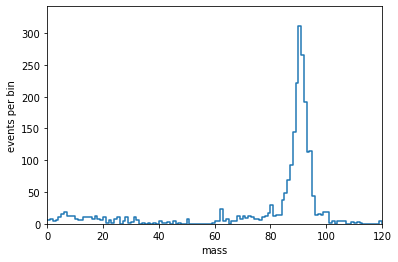

In [62]:
%matplotlib inline
import matplotlib.pyplot

counts, edges = histogram

matplotlib.pyplot.step(x=edges, y=numpy.append(counts, 0), where="post");
matplotlib.pyplot.xlim(edges[0], edges[-1]);
matplotlib.pyplot.ylim(0, counts.max() * 1.1);
matplotlib.pyplot.xlabel("mass");
matplotlib.pyplot.ylabel("events per bin");

This differs from the lazy array approach in that you need to explicitly manage the iteration, as in this histogram accumulation. However, since we aren't caching, the previous array batch is deleted as soon as `data` goes out of scope, so it is easier to control which arrays are in memory and which aren't.

Choose lazy arrays or iteration according to the degree of control you need.

## Filenames and entry numbers while iterating

[uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot.tree.iterate) crosses file boundaries as part of its iteration, and that's information we might need in the loop. If the following are `True`, each step in iteration is a tuple containing the arrays and the additional information.

   * **reportpath:** the full path or URL of the (possibly remote) file;
   * **reportfile:** the [ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory) object itself (so that you don't need to re-open it at each iteration step);
   * **reportentries:** the starting and stopping entry numbers for this chunk of data. In a multi-file iteration, these are global (always increasing, not returning to zero as we start the next file).

In [54]:
for path, file, start, stop, arrays in uproot.iterate(
    ["https://scikit-hep.org/uproot/examples/sample-%s-zlib.root" % x
        for x in ["5.23.02", "5.24.00", "5.25.02", "5.26.00", "5.27.02", "5.28.00",
                  "5.29.02", "5.30.00", "6.08.04", "6.10.05", "6.14.00"]],
    "sample",
    "f8",
     reportpath=True, reportfile=True, reportentries=True):
    print(path, file, start, stop, len(arrays))

https://scikit-hep.org/uproot/examples/sample-5.23.02-zlib.root <ROOTDirectory b'sample-5.23.02-zlib.root' at 0x7ac1160de470> 0 30 1
https://scikit-hep.org/uproot/examples/sample-5.24.00-zlib.root <ROOTDirectory b'sample-5.24.00-zlib.root' at 0x7ac1160c6160> 30 60 1
https://scikit-hep.org/uproot/examples/sample-5.25.02-zlib.root <ROOTDirectory b'sample-5.25.02-zlib.root' at 0x7ac116029cf8> 60 90 1
https://scikit-hep.org/uproot/examples/sample-5.26.00-zlib.root <ROOTDirectory b'sample-5.26.00-zlib.root' at 0x7ac116053b70> 90 120 1
https://scikit-hep.org/uproot/examples/sample-5.27.02-zlib.root <ROOTDirectory b'sample-5.27.02-zlib.root' at 0x7ac115fae7b8> 120 150 1
https://scikit-hep.org/uproot/examples/sample-5.28.00-zlib.root <ROOTDirectory b'sample-5.28.00-zlib.root' at 0x7ac115f9c5c0> 150 180 1
https://scikit-hep.org/uproot/examples/sample-5.29.02-zlib.root <ROOTDirectory b'sample-5.29.02-zlib.root' at 0x7ac115ff88d0> 180 210 1
https://scikit-hep.org/uproot/examples/sample-5.30.00-zl

## Limiting the number of entries to be read

All array-reading functions have the following parameters:

   * **entrystart:** the first entry to read, by default `0`;
   * **entrystop:** one after the last entry to read, by default `numentries`.

Setting **entrystart** and/or **entrystop** differs from slicing the resulting array in that slicing reads, then discards, but these parameters minimize the data to read.

In [55]:
len(events.array("E1", entrystart=100, entrystop=300))

200

As with Python slices, the **entrystart** and **entrystop** can be negative to count from the end of the TTree.

In [56]:
events.array("E1", entrystart=-10)

array([ 35.36458334,  35.46037568,  27.74254176,  32.67634359,
        32.67634359,  32.70165023, 168.78012134,  81.27013558,
        81.27013558,  81.56621735])

Internally, ROOT files are written in chunks and whole chunks must be read, so the best places to set **entrystart** and **entrystop** are between basket boundaries.

In [57]:
# This file has small TBaskets
tree = uproot.open("https://scikit-hep.org/uproot/examples/foriter.root")["foriter"]
branch = tree["data"]
[branch.basket_numentries(i) for i in range(branch.numbaskets)]

[6, 6, 6, 6, 6, 6, 6, 4]

In [58]:
# (entrystart, entrystop) pairs where ALL the TBranches' TBaskets align
list(tree.clusters())

[(0, 6), (6, 12), (12, 18), (18, 24), (24, 30), (30, 36), (36, 42), (42, 46)]

Or simply,

In [59]:
branch.baskets()

[array([0, 1, 2, 3, 4, 5], dtype=int32),
 array([ 6,  7,  8,  9, 10, 11], dtype=int32),
 array([12, 13, 14, 15, 16, 17], dtype=int32),
 array([18, 19, 20, 21, 22, 23], dtype=int32),
 array([24, 25, 26, 27, 28, 29], dtype=int32),
 array([30, 31, 32, 33, 34, 35], dtype=int32),
 array([36, 37, 38, 39, 40, 41], dtype=int32),
 array([42, 43, 44, 45], dtype=int32)]

## Controlling lazy chunk and iteration step sizes

In addition to **entrystart** and **entrystop**, the lazy array and iteration functions also have:

   * **entrysteps:** the number of entries to read in each chunk or step, `numpy.inf` for make the chunks/steps as big as possible (limited by file boundaries), a memory size string, or a list of `(entrystart, entrystop)` pairs to be explicit.

In [60]:
[len(chunk) for chunk in events.lazyarrays(entrysteps=500)["E1"].chunks]

[500, 500, 500, 500, 304]

In [61]:
[len(data[b"E1"]) for data in events.iterate(["E*", "p[xyz]*"], entrysteps=500)]

[500, 500, 500, 500, 304]

The TTree lazy array/iteration functions ([TTreeMethods.array](https://uproot.readthedocs.io/en/latest/ttree-handling.html#array), [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays), [TBranch.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id13), [TTreeMethods.lazyarray](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarray), and [TTreeMethods.lazyarrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#lazyarrays)) use basket or cluster sizes as a default **entrysteps**, while multi-file lazy array/iteration functions ([uproot.lazyarrays](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-lazyarray-and-lazyarrays) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate)) use the maximum per file: `numpy.inf`.

In [62]:
# This file has small TBaskets
tree = uproot.open("https://scikit-hep.org/uproot/examples/foriter.root")["foriter"]
branch = tree["data"]
[len(a["data"]) for a in tree.iterate(namedecode="utf-8")]

[6, 6, 6, 6, 6, 6, 6, 4]

In [63]:
# This file has small TBaskets
[len(a["data"]) for a in uproot.iterate(["https://scikit-hep.org/uproot/examples/foriter.root"] * 3,
                                        "foriter", namedecode="utf-8")]

[46, 46, 46]

One particularly useful way to specify the **entrysteps** is with a memory size string. This string consists of a number followed by a memory unit: `B` for bytes, `kB` for kilobytes, `MB`, `GB`, and so on (whitespace and case insensitive).

The chunks are not guaranteed to fit the memory size perfectly or even be less than the target size. Uproot picks a fixed number of events that approximates this size on average. The result depends on the number of branches chosen because it is the total size of the set of branches that are chosen for the memory target.

In [64]:
[len(data[b"E1"]) for data in events.iterate(["E*", "p[xyz]*"], entrysteps="50 kB")]

[753, 753, 753, 45]

In [65]:
[len(data[b"E1"]) for data in events.iterate(entrysteps="50 kB")]

[359, 359, 359, 359, 359, 359, 150]

Since lazy arrays represent all branches but we won't necessarily be reading all branches, memory size chunking is less useful for lazy arrays, but you can do it because all function parameters are treated consistently.

In [66]:
[len(chunk) for chunk in events.lazyarrays(entrysteps="50 kB")["E1"].chunks]

[359, 359, 359, 359, 359, 359, 150]

## Caching and iteration

Since iteration gives you more precise control over which set of events you're processing at a given time, caching with the **cache** parameter is less useful than it is with lazy arrays. For consistency's sake, the [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) functions provide a **cache** parameter and it works the same way that it does in other array-reading functions, but its effect would be to retain the previous step's arrays while working on a new step in the iteration. Presumably, the reason you're iterating is because only the current step fits into memory, so this is not a useful feature.

However, the **basketcache** is very useful for iteration, more so than it is for lazy arrays. If an iteration step falls in the middle of a TBasket, the whole TBasket must be read in that step, despite the fact that only part of it is incorporated into the output array. The remainder of the TBasket will be used in the next iteration step, so caching it for exactly one iteration step is ideal: it avoids the need to reread it and decompress it again.

It is such a useful feature that it's built into [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) by default. If you don't set a **basketcache**, these functions will create one with no memory limit and save TBaskets in it for exactly one iteration step, eliminating that temporary cache at the end of iteration. (The same is true of the **keycache**; see [reference documentation](https://uproot.readthedocs.io/en/latest/caches.html) for detail.)

Thus, you probably don't want to set any explicit caches while iterating. Setting an explicit **basketcache** would introduce an upper limit on how much it can store, but it would lose the property of evicting after exactly one iteration step (because the connection between the cache object and the iterator would be lost). If you're running out of memory during iteration, try reducing the **entrysteps**.

# Changing the output container type

When we ask for [TTreeMethods.arrays](https://uproot.readthedocs.io/en/latest/ttree-handling.html#arrays) (plural), [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate), or [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate), we get a Python dict mapping branch names to arrays. (As a reminder, **namedecode="utf-8"** makes those branch names Python strings, rather than bytestrings.) Sometimes, we want a different kind of container.

   * **outputtype:** the _type_ of the container to hold the output arrays.

One particularly useful container is `tuple`, which can be unpacked by a tuple-assignment.

In [67]:
px, py, pz = events.arrays("p[xyz]1", outputtype=tuple)

In [68]:
px

array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
        32.37749196,  32.48539387])

Using `tuple` as an **outputtype** in [TTreeMethods.iterate](https://uproot.readthedocs.io/en/latest/ttree-handling.html#iterate) and [uproot.iterate](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-iterate) lets us unpack the arrays in Python's for statement.

In [69]:
for px, py, pz in events.iterate("p[xyz]1", outputtype=tuple):
    px**2 + py**2 + pz**2

Another useful type is `collections.namedtuple`, which packs everything into a single object, but the fields are accessible by name.

In [70]:
import collections    # from the Python standard library

a = events.arrays("p[xyz]1", outputtype=collections.namedtuple)

In [71]:
a.px1

array([-41.19528764,  35.11804977,  35.11804977, ...,  32.37749196,
        32.37749196,  32.48539387])

You can also use your own classes.

In [72]:
class Stuff:
    def __init__(self, px, py, pz):
        self.p = numpy.sqrt(px**2 + py**2 + pz**2)
    def __repr__(self):
        return "<Stuff %r>" % self.p

events.arrays("p[xyz]1", outputtype=Stuff)

<Stuff array([82.20179848, 62.34483942, 62.34483942, ..., 81.27006689,
       81.27006689, 81.56614892])>

And perhaps most importantly, you can pass in [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [73]:
import pandas

events.arrays("p[xyz]1", outputtype=pandas.DataFrame, entrystop=10)

,px1,py1,pz1
entry,,,
0,-41.195288,17.433244,-68.964962
1,35.118050,-16.570362,-48.775247
2,35.118050,-16.570362,-48.775247
3,34.144437,-16.119525,-47.426984
4,22.783582,15.036444,-31.689894
5,-19.862307,-9.204225,43.817098
6,-19.862307,-9.204225,43.817098
7,-20.177373,-9.354149,44.513955
8,71.143711,29.542308,-108.150553


# Filling Pandas DataFrames

The previous example filled a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) by explicitly passing it as an **outputtype**. Pandas is such an important container type that there are specialized functions for it: [TTreeMethods.pandas.df](https://uproot.readthedocs.io/en/latest/ttree-handling.html#id7) and [uproot.pandas.df](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate).

In [74]:
events.pandas.df("p[xyz]1", entrystop=10)

,px1,py1,pz1
entry,,,
0,-41.195288,17.433244,-68.964962
1,35.118050,-16.570362,-48.775247
2,35.118050,-16.570362,-48.775247
3,34.144437,-16.119525,-47.426984
4,22.783582,15.036444,-31.689894
5,-19.862307,-9.204225,43.817098
6,-19.862307,-9.204225,43.817098
7,-20.177373,-9.354149,44.513955
8,71.143711,29.542308,-108.150553


The **entry** index in the resulting DataFrame represents the actual entry numbers in the file. For instance, counting from the end:

In [75]:
events.pandas.df("p[xyz]1", entrystart=-10)

,px1,py1,pz1
entry,,,
2294,12.966984,30.974506,11.094139
2295,13.001270,31.059021,11.123455
2296,-16.891371,-15.335677,-15.784044
2297,19.037577,14.820723,22.037447
2298,19.037577,14.820723,22.037447
2299,19.054651,14.833954,22.051323
2300,-68.041915,-26.105847,-152.235018
2301,32.377492,1.199406,-74.532431
2302,32.377492,1.199406,-74.532431


The [uproot.pandas.df](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-pandas-iterate) function doesn't have a **reportentries** because they're included in the DataFrame itself.

In [76]:
for df in uproot.pandas.iterate("https://scikit-hep.org/uproot/examples/Zmumu.root", "events", "p[xyz]1", entrysteps=500):
    print(df[:3])

         px1        py1        pz1
0 -41.195288  17.433244 -68.964962
1  35.118050 -16.570362 -48.775247
2  35.118050 -16.570362 -48.775247
           px1        py1        pz1
500  39.163212 -19.185280 -13.979333
501  39.094970 -19.152964 -13.936115
502  -7.656437 -33.431880  91.840257
            px1        py1       pz1
1000  26.043759 -17.618814 -0.567176
1001  26.043759 -17.618814 -0.567176
1002  25.996204 -17.585241 -0.568920
            px1        py1        pz1
1500  82.816840  13.262734  27.797909
1501 -11.416911  39.815352  32.349893
1502 -11.416911  39.815352  32.349893
            px1        py1       pz1
2000 -43.378378 -15.235422  3.019698
2001 -43.378378 -15.235422  3.019698
2002 -43.244422 -15.187402  3.003985


Part of the motivation for a special function is that it's the first of potentially many external connectors (Dask is another: see above). The other part is that these functions have more Pandas-friendly default parameters, such as **flatten=True**.

Flattening turns multiple values per entry (i.e. multiple particles per event) into separate DataFrame rows, maintaining the nested structure in the DataFrame index. Flattening is usually undesirable for arrays—because arrays don't have an index to record that information—but it's usually desirable for DataFrames.

In [77]:
events2 = uproot.open("https://scikit-hep.org/uproot/examples/HZZ.root")["events"]   # non-flat data

In [78]:
events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10, flatten=False)   # not the default

,MET_px,MET_py,Muon_Px,Muon_Py,Muon_Pz
entry,,,,,
0,5.912771,2.563633,"[-52.899456, 37.73778]","[-11.654672, 0.6934736]","[-8.160793, -11.307582]"
1,24.765203,-16.349110,[-0.81645936],[-24.404259],[20.199968]
2,-25.785088,16.237131,"[48.98783, 0.8275667]","[-21.723139, 29.800508]","[11.168285, 36.96519]"
3,8.619896,-22.786547,"[22.088331, 76.69192]","[-85.835464, -13.956494]","[403.84845, 335.0942]"
4,5.393139,-1.310052,"[45.17132, 39.750957]","[67.24879, 25.403667]","[-89.69573, 20.115053]"
5,-3.759475,-19.417021,"[9.22811, -5.793715]","[40.55438, -30.295189]","[-14.642164, 42.954376]"
6,23.962149,-9.049156,"[12.538717, 29.54184]","[-42.54871, -4.4455166]","[-124.44899, -26.356554]"
7,-57.533348,-20.487679,[34.88376],[-15.982724],[155.53117]
8,42.416195,-94.350861,"[-53.166973, 11.49187]","[92.02971, -4.4173865]","[35.638836, -17.473787]"


DataFrames like the above are slow (the cell entries are Python lists) and difficult to use in Pandas. Pandas doesn't have specialized functions for manipulating this kind of structure.

However, if we use the default **flatten=True**:

In [79]:
df = events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10)
df

MET_px     MET_py    Muon_Px    Muon_Py     Muon_Pz
entry subentry                                                        
0     0          5.912771   2.563633 -52.899456 -11.654672   -8.160793
      1          5.912771   2.563633  37.737782   0.693474  -11.307582
1     0         24.765203 -16.349110  -0.816459 -24.404259   20.199968
2     0        -25.785088  16.237131  48.987831 -21.723139   11.168285
      1        -25.785088  16.237131   0.827567  29.800508   36.965191
3     0          8.619896 -22.786547  22.088331 -85.835464  403.848450
      1          8.619896 -22.786547  76.691917 -13.956494  335.094208
4     0          5.393139  -1.310052  45.171322  67.248787  -89.695732
      1          5.393139  -1.310052  39.750957  25.403667   20.115053
5     0         -3.759475 -19.417021   9.228110  40.554379  -14.642164
      1         -3.759475 -19.417021  -5.793715 -30.295189   42.954376
6     0         23.962149  -9.049156  12.538717 -42.548710 -124.448990
      1         23.962149  -9.049156  29.541840  -4.445517  -26.356554
7     0        -57.533348 -20.487679  34.883759 -15.982724  155.531174
8     0         42.416195 -94.350861 -53.166973  92.029709   35.638836
      1         42.416195 -94.350861  11.491870  -4.417387  -17.473787
9     0         -1.914469 -23.963034 -67.014854  53.159172   54.412941
      1         -1.914469 -23.963034 -18.118755 -35.106167   58.036896

The particles-within-events structure is encoded in the [pandas.MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html), and we can use Pandas functions like [DataFrame.unstack](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.unstack.html) to manipulate that structure.

In [80]:
df.unstack()

MET_px                MET_py               Muon_Px             \
subentry          0          1          0          1          0          1   
entry                                                                        
0          5.912771   5.912771   2.563633   2.563633 -52.899456  37.737782   
1         24.765203        NaN -16.349110        NaN  -0.816459        NaN   
2        -25.785088 -25.785088  16.237131  16.237131  48.987831   0.827567   
3          8.619896   8.619896 -22.786547 -22.786547  22.088331  76.691917   
4          5.393139   5.393139  -1.310052  -1.310052  45.171322  39.750957   
5         -3.759475  -3.759475 -19.417021 -19.417021   9.228110  -5.793715   
6         23.962149  23.962149  -9.049156  -9.049156  12.538717  29.541840   
7        -57.533348        NaN -20.487679        NaN  34.883759        NaN   
8         42.416195  42.416195 -94.350861 -94.350861 -53.166973  11.491870   
9         -1.914469  -1.914469 -23.963034 -23.963034 -67.014854 -18.118755   

            Muon_Py                Muon_Pz              
subentry          0          1           0           1  
entry                                                   
0        -11.654672   0.693474   -8.160793  -11.307582  
1        -24.404259        NaN   20.199968         NaN  
2        -21.723139  29.800508   11.168285   36.965191  
3        -85.835464 -13.956494  403.848450  335.094208  
4         67.248787  25.403667  -89.695732   20.115053  
5         40.554379 -30.295189  -14.642164   42.954376  
6        -42.548710  -4.445517 -124.448990  -26.356554  
7        -15.982724        NaN  155.531174         NaN  
8         92.029709  -4.417387   35.638836  -17.473787  
9         53.159172 -35.106167   54.412941   58.036896

There's also a **flatten=None** that skips all non-flat TBranches, included as a convenience against overzealous branch selection.

In [81]:
events2.pandas.df(["MET_p*", "Muon_P*"], entrystop=10, flatten=None)

,MET_px,MET_py
entry,,
0,5.912771,2.563633
1,24.765203,-16.349110
2,-25.785088,16.237131
3,8.619896,-22.786547
4,5.393139,-1.310052
5,-3.759475,-19.417021
6,23.962149,-9.049156
7,-57.533348,-20.487679
8,42.416195,-94.350861


# Selecting and interpreting branches

We have already seen that TBranches can be selected as lists of strings and with wildcards. This is the same wildcard pattern that filesystems use to match file lists: `*` can be replaced with any text (or none), `?` can be replaced by one character, and `[...]` specifies a list of alternate characters.

Wildcard patters are quick to write, but limited relative to regular expressions. Any branch request between slashes (`/` inside the quotation marks) will be interpreted as regular expressions instead (i.e. `.*` instead of `*`).

In [82]:
events.arrays("p[xyz]?").keys()      # using wildcards

dict_keys([b'px1', b'py1', b'pz1', b'px2', b'py2', b'pz2'])

In [83]:
events.arrays("/p[x-z].?/").keys()   # using regular expressions

dict_keys([b'px1', b'py1', b'pz1', b'px2', b'py2', b'pz2'])

If, instead of strings, you pass a function from branch objects to `True` or `False`, the branches will be selected by evaluating the function as a filter. This is a way of selecting branches based on properties other than their names.

In [84]:
events.arrays(lambda branch: branch.compressionratio() > 3).keys()

dict_keys([b'Type', b'Run', b'Event', b'Q1', b'Q2'])

Note that the return values must be strictly `True` and `False`, not anything that [Python evaluates to true or false](https://itnext.io/you-shouldnt-use-truthy-tests-753b39ef8893). If the function returns anything else, it will be used as a new [Interpretation](https://uproot.readthedocs.io/en/latest/interpretation.html) for the branch.

## TBranch interpretations

The very first thing we looked at when we opened a TTree was its TBranches and their interpretations with the `show` method:

In [85]:
events.show()

Type                       (no streamer)              asstring()
Run                        (no streamer)              asdtype('>i4')
Event                      (no streamer)              asdtype('>i4')
E1                         (no streamer)              asdtype('>f8')
px1                        (no streamer)              asdtype('>f8')
py1                        (no streamer)              asdtype('>f8')
pz1                        (no streamer)              asdtype('>f8')
pt1                        (no streamer)              asdtype('>f8')
eta1                       (no streamer)              asdtype('>f8')
phi1                       (no streamer)              asdtype('>f8')
Q1                         (no streamer)              asdtype('>i4')
E2                         (no streamer)              asdtype('>f8')
px2                        (no streamer)              asdtype('>f8')
py2                        (no streamer)              asdtype('>f8')
pz2                        (no streame

Every branch has a default interpretation, such as

In [86]:
events["E1"].interpretation

asdtype('>f8')

meaning big-endian, 8-byte floating point numbers as a [Numpy dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html). We could interpret this branch with a different [Numpy dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html), but it wouldn't be meaningful.

In [87]:
events["E1"].array(uproot.asdtype(">i8"))

array([4635484859043618393, 4633971086021346367, 4633971086021346367, ...,
       4635419294316473354, 4635419294316473354, 4635440129219414362])

Instead of reading the values as floating point numbers, we've read them as integers. It's unlikely that you'd ever want to do that, unless the default interpretation is wrong.

## Reading data into a preexisting array

One actually useful TBranch reinterpretation is [uproot.asarray](https://uproot.readthedocs.io/en/latest/interpretation.html#uproot-interp-numerical-asarray). It differs from [uproot.asdtype](https://uproot.readthedocs.io/en/latest/interpretation.html#uproot-interp-numerical-asdtype) only in that the latter creates a new array when reading data while the former fills a user-specified array.

In [88]:
myarray = numpy.zeros(events.numentries, dtype=numpy.float32)    # (different size)
reinterpretation = events["E1"].interpretation.toarray(myarray)
reinterpretation

asarray('>f8', <array float32 (2304,) at 0x7ac115f23490>)

Passing the new [uproot.asarray](https://uproot.readthedocs.io/en/latest/interpretation.html#uproot-interp-numerical-asarray) interpretation to the array-reading function

In [89]:
events["E1"].array(reinterpretation)

array([82.201866, 62.34493 , 62.34493 , ..., 81.270134, 81.270134,
       81.566216], dtype=float32)

fills and returns that array. When you look at my array object, you can see that it is now filled, overwriting whatever might have been in it before.

In [90]:
myarray

array([82.201866, 62.34493 , 62.34493 , ..., 81.270134, 81.270134,
       81.566216], dtype=float32)

This is useful for speed-critical applications or ones in which the array is managed by an external system. The array could be NUMA-allocated in a supercomputer or CPU/GPU managed by PyTorch, for instance.

As the provider of the array, it is your responsibility to ensure that it has enough elements to hold the (possibly type-converted) output. (Failure to do so only results in an exception, not a segmentation fault or anything.)

## Passing many new interpretations in one call

Above, you saw what happens when a TBranch selector is a function returning `True` or `False`, and I stressed that it must be literally `True`, not an object that Python would evaluate to `True`.

In [91]:
events.arrays(lambda branch: isinstance(branch.interpretation, uproot.asdtype) and
                             str(branch.interpretation.fromdtype) == ">f8").keys()

dict_keys([b'E1', b'px1', b'py1', b'pz1', b'pt1', b'eta1', b'phi1', b'E2', b'px2', b'py2', b'pz2', b'pt2', b'eta2', b'phi2', b'M'])

This is because a function that returns objects selects branches and sets their interpretations in one pass.

In [92]:
events.arrays(lambda branch: uproot.asdtype(">f8", "<f4") if branch.name.startswith(b"px") else None)

{b'px1': array([-41.195286,  35.11805 ,  35.11805 , ...,  32.37749 ,  32.37749 ,
         32.485394], dtype=float32),
 b'px2': array([ 34.144436, -41.195286, -40.883324, ..., -68.041916, -68.794136,
        -68.794136], dtype=float32)}

The above selects TBranch names that start with `"px"`, read-interprets them as big-endian 8-byte floats and writes them as little-endian 4-byte floats. The selector returns `None` for the TBranches to exclude and an [Interpretation](https://uproot.readthedocs.io/en/latest/interpretation.html) for the ones to reinterpret.

The same could have been said in a less functional way with a dict:

In [93]:
events.arrays({"px1": uproot.asdtype(">f8", "<f4"),
               "px2": uproot.asdtype(">f8", "<f4")})

{b'px1': array([-41.195286,  35.11805 ,  35.11805 , ...,  32.37749 ,  32.37749 ,
         32.485394], dtype=float32),
 b'px2': array([ 34.144436, -41.195286, -40.883324, ..., -68.041916, -68.794136,
        -68.794136], dtype=float32)}

## Multiple values per event: fixed size arrays

So far, you've seen a lot of examples with one value per event, but multiple values per event are very common. In the simplest case, the value in each event is a vector, matrix, or tensor with a fixed number of dimensions, such as a 3-vector or a set of parton weights from a Monte Carlo.

Here's an artificial example:

In [94]:
tree = uproot.open("https://scikit-hep.org/uproot/examples/nesteddirs.root")["one/two/tree"]
array = tree.array("ArrayInt64", entrystop=20)
array

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1],
       [ 2,  2,  2,  2,  2,  2,  2,  2,  2,  2],
       [ 3,  3,  3,  3,  3,  3,  3,  3,  3,  3],
       [ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4],
       [ 5,  5,  5,  5,  5,  5,  5,  5,  5,  5],
       [ 6,  6,  6,  6,  6,  6,  6,  6,  6,  6],
       [ 7,  7,  7,  7,  7,  7,  7,  7,  7,  7],
       [ 8,  8,  8,  8,  8,  8,  8,  8,  8,  8],
       [ 9,  9,  9,  9,  9,  9,  9,  9,  9,  9],
       [10, 10, 10, 10, 10, 10, 10, 10, 10, 10],
       [11, 11, 11, 11, 11, 11, 11, 11, 11, 11],
       [12, 12, 12, 12, 12, 12, 12, 12, 12, 12],
       [13, 13, 13, 13, 13, 13, 13, 13, 13, 13],
       [14, 14, 14, 14, 14, 14, 14, 14, 14, 14],
       [15, 15, 15, 15, 15, 15, 15, 15, 15, 15],
       [16, 16, 16, 16, 16, 16, 16, 16, 16, 16],
       [17, 17, 17, 17, 17, 17, 17, 17, 17, 17],
       [18, 18, 18, 18, 18, 18, 18, 18, 18, 18],
       [19, 19, 19, 19, 19, 19, 19, 19, 19, 19]])

The resulting array has a non-trivial [Numpy shape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.shape.html), but otherwise, it has the same [Numpy array type](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) as the other arrays you've seen (apart from lazy arrays—`ChunkedArray` and `VirtualArray`—which are not Numpy objects).

In [95]:
array.shape

(20, 10)

All but the first dimension of the shape parameter (the "length") is known before reading the array: it's the [dtype shape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.shape.html).

In [96]:
tree["ArrayInt64"].interpretation

asdtype("('>i8', (10,))")

In [97]:
tree["ArrayInt64"].interpretation.todtype.shape

(10,)

The [dtype shape](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dtype.shape.html) of a TBranch with one value per event (simple, 1-dimensional arrays) is an empty tuple.

In [98]:
tree["Int64"].interpretation.todtype.shape

()

Fixed-width arrays are exploded into one column per element when viewed as a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [99]:
tree.pandas.df("ArrayInt64", entrystop=20)

,ArrayInt64[0],ArrayInt64[1],ArrayInt64[2],ArrayInt64[3],ArrayInt64[4],ArrayInt64[5],ArrayInt64[6],ArrayInt64[7],ArrayInt64[8],ArrayInt64[9]
entry,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,1,1,1,1,1,1
2,2,2,2,2,2,2,2,2,2,2
3,3,3,3,3,3,3,3,3,3,3
4,4,4,4,4,4,4,4,4,4,4
5,5,5,5,5,5,5,5,5,5,5
6,6,6,6,6,6,6,6,6,6,6
7,7,7,7,7,7,7,7,7,7,7
8,8,8,8,8,8,8,8,8,8,8


## Multiple values per event: leaf-lists

Another of ROOT's fundamental TBranch types is a "[leaf-list](https://root.cern.ch/root/htmldoc/guides/users-guide/Trees.html#adding-a-branch-to-hold-a-list-of-variables)," or a TBranch with multiple TLeaves. (**Note:** in ROOT terminology, "TBranch" is a data structure that usually points to data in TBaskets and "TLeaf" is the _data type_ descriptor. TBranches and TLeaves have no relationship to the interior and endpoints of a tree structure in computer science.)

The Numpy analogue of a leaf-list is a [structured array](https://docs.scipy.org/doc/numpy/user/basics.rec.html), a [dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html) with named fields, which is Numpy's view into a C array of structs (with or without padding).

In [100]:
tree = uproot.open("https://scikit-hep.org/uproot/examples/leaflist.root")["tree"]
array = tree.array("leaflist")
array

array([(1.1, 1,  97), (2.2, 2,  98), (3.3, 3,  99), (4. , 4, 100),
       (5.5, 5, 101)], dtype=[('x', '<f8'), ('y', '<i4'), ('z', 'i1')])

This array is presented as an array of tuples, though it's actually a contiguous block of memory with floating point numbers (`"x"`), integers (`"y"`), and single characters (`"z"`) adjacent to each other.

In [101]:
array[0]

(1.1, 1, 97)

In [102]:
array["x"]

array([1.1, 2.2, 3.3, 4. , 5.5])

In [103]:
array["y"]

array([1, 2, 3, 4, 5], dtype=int32)

In [104]:
array["z"]

array([ 97,  98,  99, 100, 101], dtype=int8)

The [dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html) for this array defines the field stucture. Its [item size](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.itemsize.html) is `8 + 4 + 1 = 13`, not a power of 2, as arrays of primitive types are.

In [105]:
array.dtype

dtype([('x', '<f8'), ('y', '<i4'), ('z', 'i1')])

In [106]:
array.dtype.itemsize

13

ROOT TBranches may have multiple values per event _and_ a leaf-list structure, and [Numpy arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) may have non-trivial shape _and_ [dtype fields](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html), so the translation between ROOT and Numpy is one-to-one.

Leaf-list TBranches are exploded into one column per field when viewed as a [pandas.DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html).

In [107]:
tree.pandas.df("leaflist")

,leaflist.x,leaflist.y,leaflist.z
entry,,,
0,1.1,1,97
1,2.2,2,98
2,3.3,3,99
3,4.0,4,100
4,5.5,5,101


The **flatname** parameter determines how fixed-width arrays and field names are translated into Pandas names; the default is `uproot._connect._pandas.default_flatname` (a function from **branchname** _(str)_, **fieldname** _(str)_, **index** _(int)_ to Pandas column name _(str)_).

## Multiple values per event: jagged arrays

In physics data, it is even more common to have an arbitrary number of values per event than a fixed number of values per event. Consider, for instance, particles produced in a collision, tracks in a jet, hits on a track, etc.

Unlike fixed-width arrays and a fixed number of fields per element, Numpy has no analogue for this type. It is fundamentally outside of Numpy's scope because Numpy describes rectangular tables of data. As we have seen above, Pandas has some support for this so-called "jagged" (sometimes "ragged") data, but only through manipulation of its index ([pandas.MultiIndex](https://pandas.pydata.org/pandas-docs/stable/user_guide/advanced.html)), not the data themselves.

For this, uproot fills a new `JaggedArray` data structure (from the awkward-array library, like `ChunkedArray` and `VirtualArray`).

In [108]:
tree = uproot.open("https://scikit-hep.org/uproot/examples/nesteddirs.root")["one/two/tree"]
array = tree.array("SliceInt64", entrystop=20)
array

<JaggedArray [[] [1] [2 2] ... [17 17 17 ... 17 17 17] [18 18 18 ... 18 18 18] [19 19 19 ... 19 19 19]] at 0x7ac11614ae10>

These `JaggedArrays` are made of [Numpy arrays](https://docs.scipy.org/doc/numpy/reference/generated/numpy.array.html) and follow the same [Numpy slicing rules](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html), including [advanced indexing](https://docs.scipy.org/doc/numpy/reference/arrays.indexing.html#advanced-indexing).

Awkward-array generalizes Numpy in many ways—details can be found [in its documentation](https://github.com/scikit-hep/awkward-array).

In [109]:
array.counts

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [110]:
array.flatten()

array([ 1,  2,  2,  3,  3,  3,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,
        6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,
        8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9, 11, 12, 12, 13, 13, 13,
       14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17,
       17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19,
       19, 19, 19, 19, 19])

In [111]:
array[:6]

<JaggedArray [[] [1] [2 2] [3 3 3] [4 4 4 4] [5 5 5 5 5]] at 0x7ac1160f18d0>

In [112]:
array[array.counts > 1, 0]

array([ 2,  3,  4,  5,  6,  7,  8,  9, 12, 13, 14, 15, 16, 17, 18, 19])

Here is an example of `JaggedArrays` in physics data:

In [113]:
events2 = uproot.open("https://scikit-hep.org/uproot/examples/HZZ.root")["events"]

In [114]:
E, px, py, pz = events2.arrays(["Muon_E", "Muon_P[xyz]"], outputtype=tuple)
E

<JaggedArray [[54.7795 39.401695] [31.690445] [54.739788 47.488857] ... [62.39516] [174.20863] [69.55621]] at 0x7ac115fad128>

In [115]:
pt = numpy.sqrt(px**2 + py**2)
p = numpy.sqrt(px**2 + py**2 + pz**2)
p

<JaggedArray [[54.7794 39.401554] [31.69027] [54.739685 47.48874] ... [62.395073] [174.2086] [69.55613]] at 0x7ac1160214e0>

In [116]:
eta = numpy.log((p + pz)/(p - pz))/2
eta

<JaggedArray [[-0.15009262 -0.29527554] [0.7538137] [0.2069292 1.0412954] ... [-1.2350469] [1.6653312] [1.0626991]] at 0x7ac116021ac8>

In [117]:
phi = numpy.arctan2(py, px)
phi

<JaggedArray [[-2.9247396 0.01837404] [-1.6042395] [-0.41738483 1.5430332] ... [-2.666572] [1.552847] [-0.980149]] at 0x7ac115f5ccc0>

In [118]:
pt.counts

array([2, 1, 2, ..., 1, 1, 1])

In [119]:
pt.flatten()

array([54.168106, 37.744152, 24.417913, ..., 33.461536, 63.619816,
       42.93995 ], dtype=float32)

In [120]:
pt[:6]

<JaggedArray [[54.168106 37.744152] [24.417913] [53.58827 29.811996] [88.63194 77.951485] [81.011406 47.175045] [41.591053 30.844215]] at 0x7ac116021748>

Note that if you want to histogram the inner contents of these arrays (i.e. histogram of particles, ignoring event boundaries), functions like [numpy.histogram](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html) require non-jagged arrays, so flatten them with a call to `.flatten()`.

To select elements of inner lists (Pandas's [DataFrame.xs](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.xs.html)), first require the list to have at least that many elements.

In [121]:
pt[pt.counts > 1, 0]

array([54.168106, 53.58827 , 88.63194 , ..., 58.38824 , 61.645054,
       44.971596], dtype=float32)

`JaggedArrays` of booleans select from inner lists (i.e. put a cut on particles):

In [122]:
pt > 50

<JaggedArray [[True False] [False] [True False] ... [False] [True] [False]] at 0x7ac115f5c438>

In [123]:
eta[pt > 50]

<JaggedArray [[-0.15009262] [] [0.2069292] ... [] [1.6653312] []] at 0x7ac116021780>

And Numpy arrays of booleans select from outer lists (i.e. put a cut on events):

In [124]:
eta[pt.max() > 50]

<JaggedArray [[-0.15009262 -0.29527554] [0.2069292 1.0412954] [2.2215228 2.1647348] ... [0.23674133 0.49973577] [-0.38897678 -0.013611516] [1.6653312]] at 0x7ac115f5c550>

Reducers like `count`, `sum`, `min`, `max`, `any` (boolean), or `all` (boolean) apply per-event, turning a `JaggedArray` into a Numpy array.

In [125]:
pt.max()

array([54.168106, 24.417913, 53.58827 , ..., 33.461536, 63.619816,
       42.93995 ], dtype=float32)

You can even do combinatorics, such as `a.cross(b)` to compute the Cartesian product of `a` and `b` per event, or `a.choose(n)` to choose `n` distinct combinations of elements per event.

In [126]:
pt.choose(2)

<JaggedArray [[(54.168106, 37.744152)] [] [(53.58827, 29.811996)] ... [] [] []] at 0x7ac115f3d048>

Some of these functions have "arg" versions that return integers, which can be used in indexing.

In [127]:
abs(eta).argmax()

<JaggedArray [[1] [0] [1] ... [0] [0] [0]] at 0x7ac1a8343da0>

In [128]:
pairs = pt.argchoose(2)
pairs

<JaggedArray [[(0, 1)] [] [(0, 1)] ... [] [] []] at 0x7ac1a8c25f60>

In [129]:
left  = pairs.i0
right = pairs.i1
left, right

(<JaggedArray [[0] [] [0] ... [] [] []] at 0x7ac115f5c1d0>,
 <JaggedArray [[1] [] [1] ... [] [] []] at 0x7ac115f5c400>)

Masses of unique pairs of muons, for events that have them:

In [130]:
masses = numpy.sqrt((E[left] + E[right])**2 - (px[left] + px[right])**2 -
                    (py[left] + py[right])**2 - (pz[left] + pz[right])**2)
masses

<JaggedArray [[90.227806] [] [74.746544] ... [] [] []] at 0x7ac1a83ee828>

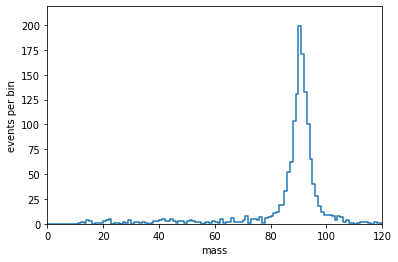

In [131]:
counts, edges = numpy.histogram(masses.flatten(), bins=120, range=(0, 120))

matplotlib.pyplot.step(x=edges, y=numpy.append(counts, 0), where="post");
matplotlib.pyplot.xlim(edges[0], edges[-1]);
matplotlib.pyplot.ylim(0, counts.max() * 1.1);
matplotlib.pyplot.xlabel("mass");
matplotlib.pyplot.ylabel("events per bin");

## Jagged array performance

`JaggedArrays` are compact in memory and fast to read. Whereas [root_numpy](https://pypi.org/project/root-numpy/) reads data like `std::vector<float>` per event into a Numpy array of Numpy arrays (Numpy's object `"O"` [dtype](https://docs.scipy.org/doc/numpy/reference/arrays.dtypes.html)), which has data locality issues, `JaggedArray` consists of two contiguous arrays: one containing content (the `floats`) and the other representing structure via `offsets` (random access) or `counts`.

In [132]:
masses.content

array([90.227806, 74.746544, 89.75766 , ..., 92.06495 , 85.44384 ,
       75.96062 ], dtype=float32)

In [133]:
masses.offsets

array([   0,    1,    1, ..., 1521, 1521, 1521])

In [134]:
masses.counts

array([1, 0, 1, ..., 0, 0, 0])

Fortunately, ROOT files are themselves structured this way, with variable-width data represented by contents and offsets in a TBasket. These arrays do not need to be deserialized individually, but can be merely cast as Numpy arrays in one Python call. The lack of per-event processing is why reading in uproot and processing data with awkward-array can be fast, despite being written in Python.

<br>

<center><img src="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/logscales.png" width="75%"></center>

## Special physics objects: Lorentz vectors

Although any C++ type can in principle be read (see below), some are important enough to be given convenience methods for analysis. These are not defined in uproot (which is strictly concerned with I/O), but in [uproot-methods](https://github.com/scikit-hep/uproot-methods). If you need certain classes to have user-friendly methods in Python, you're encouraged to contribute them to [uproot-methods](https://github.com/scikit-hep/uproot-methods).

One of these classes is `TLorentzVectorArray`, which defines an _array_ of Lorentz vectors.

In [135]:
events3 = uproot.open("https://scikit-hep.org/uproot/examples/HZZ-objects.root")["events"]

In [136]:
muons = events3.array("muonp4")
muons

<JaggedArrayMethods [[TLorentzVector(x=-52.899, y=-11.655, z=-8.1608, t=54.779) TLorentzVector(x=37.738, y=0.69347, z=-11.308, t=39.402)] [TLorentzVector(x=-0.81646, y=-24.404, z=20.2, t=31.69)] [TLorentzVector(x=48.988, y=-21.723, z=11.168, t=54.74) TLorentzVector(x=0.82757, y=29.801, z=36.965, t=47.489)] ... [TLorentzVector(x=-29.757, y=-15.304, z=-52.664, t=62.395)] [TLorentzVector(x=1.1419, y=63.61, z=162.18, t=174.21)] [TLorentzVector(x=23.913, y=-35.665, z=54.719, t=69.556)]] at 0x7ac115ec03c8>

In the print-out, these appear to be Python objects, but they're high-performance arrays that are only turned into objects when you look at individuals.

In [137]:
muon = muons[0, 0]
type(muon), muon

(uproot_methods.classes.TLorentzVector.TLorentzVector,
 TLorentzVector(x=-52.899, y=-11.655, z=-8.1608, t=54.779))

This object has all the usual kinematics methods,

In [138]:
muon.mass

0.10559298741436905

In [139]:
muons[0, 0].delta_phi(muons[0, 1])

-2.9431136434497858

But an array of Lorentz vectors also has these methods, and they are computed in bulk (faster than creating each object and calling the method on each).

In [9]:
muons.mass   # some mass**2 are slightly negative, hence the Numpy warning about negative square roots

NameError: name 'muons' is not defined

(**Note:** if you don't want to see Numpy warnings, use [numpy.seterr](https://docs.scipy.org/doc/numpy/reference/generated/numpy.seterr.html).)

In [141]:
pairs = muons.choose(2)
lefts  = pairs.i0
rights = pairs.i1
lefts.delta_r(rights)

<JaggedArray [[2.9466923822257822] [] [2.1305881273993306] ... [] [] []] at 0x7ac11616cc88>

TBranches with C++ class `TLorentzVector` are automatically converted into `TLorentzVectorArrays`. Although they're in wide use, the C++ `TLorentzVector` class is deprecated in favor of [ROOT::Math::LorentzVector](https://root.cern/doc/v612/classROOT_1_1Math_1_1LorentzVector.html). Unlike the old class, the new vectors can be represented with a variety of data types and coordinate systems, and they're split into multiple branches, so uproot sees them as four branches, each representing the components.

You can still use the `TLorentzVectorArray` Python class; you just need to use a special constructor to build the object from its branches.

In [142]:
# Suppose you have four component branches...
E, px, py, pz = events2.arrays(["Muon_E", "Muon_P[xyz]"], outputtype=tuple)

In [143]:
import uproot_methods

array = uproot_methods.TLorentzVectorArray.from_cartesian(px, py, pz, E)
array

<JaggedArrayMethods [[TLorentzVector(x=-52.899, y=-11.655, z=-8.1608, t=54.779) TLorentzVector(x=37.738, y=0.69347, z=-11.308, t=39.402)] [TLorentzVector(x=-0.81646, y=-24.404, z=20.2, t=31.69)] [TLorentzVector(x=48.988, y=-21.723, z=11.168, t=54.74) TLorentzVector(x=0.82757, y=29.801, z=36.965, t=47.489)] ... [TLorentzVector(x=-29.757, y=-15.304, z=-52.664, t=62.395)] [TLorentzVector(x=1.1419, y=63.61, z=162.18, t=174.21)] [TLorentzVector(x=23.913, y=-35.665, z=54.719, t=69.556)]] at 0x7ac10fe63908>

There are constructors for different coordinate systems. Internally, `TLorentzVectorArray` uses the coordinates you give it and only converts to other systems on demand.

In [144]:
[x for x in dir(uproot_methods.TLorentzVectorArray) if x.startswith("from_")]

['from_cartesian',
 'from_cylindrical',
 'from_p3',
 'from_ptetaphi',
 'from_ptetaphie',
 'from_ptetaphim',
 'from_spherical',
 'from_xyzm']

## Variable-width values: strings

Strings are another fundamental type. In C++, they may be `char*`, `std::string`, or `TString`, but all string types are converted (on demand) to the same Python string type.

In [145]:
branch = uproot.open("https://scikit-hep.org/uproot/examples/sample-6.14.00-zlib.root")["sample"]["str"]
branch.array()

<ObjectArray [b'hey-0' b'hey-1' b'hey-2' ... b'hey-27' b'hey-28' b'hey-29'] at 0x7ac109e0efd0>

As with most strings from ROOT, they are unencoded bytestrings (see the `b` before each quote). Since they're not names, there's no **namedecode**, but they can be decoded as needed using the usual Python method.

In [146]:
[x.decode("utf-8") for x in branch.array()]

['hey-0',
 'hey-1',
 'hey-2',
 'hey-3',
 'hey-4',
 'hey-5',
 'hey-6',
 'hey-7',
 'hey-8',
 'hey-9',
 'hey-10',
 'hey-11',
 'hey-12',
 'hey-13',
 'hey-14',
 'hey-15',
 'hey-16',
 'hey-17',
 'hey-18',
 'hey-19',
 'hey-20',
 'hey-21',
 'hey-22',
 'hey-23',
 'hey-24',
 'hey-25',
 'hey-26',
 'hey-27',
 'hey-28',
 'hey-29']

## Arbitrary objects in TTrees

Uproot does not have a hard-coded deserialization for every C++ class type; it uses the "streamers" that ROOT includes in each file to learn how to deserialize the objects in that file. Even if you defined your own C++ classes, uproot should be able to read them. (**Caveat:** not all structure types have been implemented, so the coverage of C++ types is a work in progress.)

In some cases, the deserialization is simplified by the fact that ROOT has "split" the objects. Instead of seeing a `JaggedArray` of objects, you see a `JaggedArray` of each attribute separately, such as the components of a [ROOT::Math::LorentzVector](https://root.cern/doc/v612/classROOT_1_1Math_1_1LorentzVector.html).

In the example below, `Track` objects under `fTracks` have been split into `fTracks.fUniqueID`, `fTracks.fBits`, `fTracks.fPx`, `fTracks.fPy`, `fTracks.fPz`, etc.

In [150]:
!wget https://scikit-hep.org/uproot/examples/Event.root

--2019-12-18 07:20:26--  https://scikit-hep.org/uproot/examples/Event.root
Resolving scikit-hep.org (scikit-hep.org)... 185.199.109.153, 185.199.108.153, 185.199.111.153, ...
Connecting to scikit-hep.org (scikit-hep.org)|185.199.109.153|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37533466 (36M) [application/octet-stream]
Saving to: ‘Event.root’

Event.root          100%[===================>]  35.79M  3.63MB/s    in 11s     

2019-12-18 07:20:37 (3.35 MB/s) - ‘Event.root’ saved [37533466/37533466]



In [151]:
tree = uproot.open("Event.root")["T"]
tree.show()

event                      TStreamerInfo              None
TObject                    TStreamerInfo              None
fUniqueID                  TStreamerBasicType         asdtype('>u4')
fBits                      TStreamerBasicType         asdtype('>u4')

fType[20]                  TStreamerBasicType         asdtype("('i1', (20,))")
fEventName                 TStreamerBasicType         asstring(4)
fNtrack                    TStreamerBasicType         asdtype('>i4')
fNseg                      TStreamerBasicType         asdtype('>i4')
fNvertex                   TStreamerBasicType         asdtype('>u4')
fFlag                      TStreamerBasicType         asdtype('>u4')
fTemperature               TStreamerBasicType         asdtype('>f4', 'float64')
fMeasures[10]              TStreamerBasicType         asdtype("('>i4', (10,))")
fMatrix[4][4]              TStreamerBasicType         asdtype("('>f4', (4, 4))", "('<f8', (4, 4))")
fClosestDistance           TStreamerBasicPointer      None
fEv

In this view, many of the attributes are _not_ special classes and can be read as arrays of numbers,

In [152]:
tree.array("fTemperature", entrystop=20)

array([20.28261757, 20.47114182, 20.5931778 , 20.5848484 , 20.80287933,
       20.2972393 , 20.30301666, 20.87490845, 20.56552505, 20.67128181,
       20.74524879, 20.85200119, 20.26188469, 20.82903862, 20.02412415,
       20.97918129, 20.71551132, 20.60189629, 20.11310196, 20.53161049])

as arrays of fixed-width matrices,

In [153]:
tree.array("fMatrix[4][4]", entrystop=6)

array([[[ 1.54053164,  0.09474282,  1.52469206,  0.        ],
        [-0.13630907,  0.80078429,  1.70623565,  0.        ],
        [-1.16029346,  2.012362  ,  4.02206421,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[ 0.41865557,  1.60363352, -0.56923842,  0.        ],
        [ 0.06950195,  0.79105824,  2.0322361 ,  0.        ],
        [ 0.05688119,  2.52811217,  3.91394544,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[-1.24031985,  2.3477006 , -0.67482847,  0.        ],
        [ 1.22933233,  1.39499295,  2.17524433,  0.        ],
        [ 0.18559125,  2.40421987,  4.56326485,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],

       [[-0.43785933, -0.05061727,  0.28988785,  0.        ],
        [-0.90204114,  0.88527524,  2.34751844,  0.        ],
        [ 0.3241719 ,  0.79971647,  4.13229847,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.        ]],



as jagged arrays (of ROOT's "Float16_t" encoding),

In [154]:
tree.array("fTracks.fMass2", entrystop=6)

<JaggedArray [[4.5 4.5 4.5 ... 4.5 4.5 4.5] [4.5 4.5 4.5 ... 4.5 4.5 4.5] [8.90625 8.90625 8.90625 ... 8.90625 8.90625 8.90625] [8.90625 8.90625 8.90625 ... 8.90625 8.90625 8.90625] [8.90625 8.90625 8.90625 ... 8.90625 8.90625 8.90625] [4.5 4.5 4.5 ... 4.5 4.5 4.5]] at 0x7ac105a13588>

or as jagged arrays of fixed arrays (of ROOT's "Double32_t" encoding),

In [155]:
tree.array("fTracks.fTArray[3]", entrystop=6)

<JaggedArray [[[8.783523 17.513435 29.286354] [12.712547 18.882881 32.797363] [11.507339 19.916798 30.246092] ... [10.574707 18.890305 33.728233] [12.15555 18.71774 27.312075] [9.859776 19.74885 29.493528]] [[11.219862 21.20887 30.624903] [11.040182 24.79719 31.77871] [10.012672 20.93199 30.9403] ... [11.168169 23.217058 32.748943] [9.50235 21.121288 31.071629] [10.8550205 16.183943 26.904243]] [[8.624067 18.600851 26.04787] [10.689135 20.227545 29.83834] [11.296425 21.689695 27.481518] ... [10.669026 17.53861 27.396368] [10.695017 21.800402 29.768854] [9.190737 19.556316 30.239576]] [[10.730627 21.374237 29.189438] [10.917027 17.502947 24.684587] [10.719291 15.140461 30.947819] ... [11.342936 21.652617 30.104565] [10.155848 19.01908 31.161093] [9.246191 18.550188 29.727875]] [[11.012184 18.038168 25.433424] [9.5870495 19.802078 30.07635] [10.900804 19.059767 28.11974] ... [10.958439 19.644995 24.516222] [9.493415 19.871706 30.69776] [9.26706 21.658216 36.870094]] [[10.6818 23.174397 3

However, some types are not fully split by ROOT and have to be deserialized individually (not vectorally). This example includes _histograms_ in the TTree, and histograms are sufficiently complex that they cannot be split.

In [156]:
tree.array("fH", entrystop=6)

<ObjectArray [<b'TH1F' b'hstat' 0x7ac105a8a9a8> <b'TH1F' b'hstat' 0x7ac105a8a9f8> <b'TH1F' b'hstat' 0x7ac105a8a7c8> <b'TH1F' b'hstat' 0x7ac105a8a9a8> <b'TH1F' b'hstat' 0x7ac105a8a9f8> <b'TH1F' b'hstat' 0x7ac105a8a7c8>] at 0x7ac116114438>

Each of those is a standard histogram object, something that would ordinarily be in a `TDirectory`, not a `TTree`. It has histogram convenience methods (see below).

In [157]:
for histogram in tree.array("fH", entrystop=3):
    print(histogram.title)
    print(histogram.values)
print("\n...\n")
for histogram in tree.array("fH", entrystart=-3):
    print(histogram.title)
    print(histogram.values)

b'Event Histogram'
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
b'Event Histogram'
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
b'Event Histogram'
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]

...

b'Event Histogram'


The criteria for whether an object can be read vectorially in Numpy (fast) or individually in Python (slow) is whether it has a fixed width—all objects having the same number of bytes—or a variable width. You can see this in the TBranch's `interpretation` as the distinction between [uproot.asobj](https://uproot.readthedocs.io/en/latest/interpretation.html#uproot-interp-objects-asobj) (fixed width, vector read) and [uproot.asgenobj](https://uproot.readthedocs.io/en/latest/interpretation.html#uproot-interp-objects-asgenobj) (variable width, read into Python objects).

In [158]:
# TLorentzVectors all have the same number of fixed width components, so they can be read vectorially.
events3["muonp4"].interpretation

asjagged(asobj(<uproot_methods.classes.TLorentzVector.Methods>), 10)

In [159]:
# Histograms contain name strings and variable length lists, so they must be read as Python objects.
tree["fH"].interpretation

asgenobj(TH1F)

## Doubly nested jagged arrays (i.e. `std::vector<std::vector<T>>`)

Variable length lists are an exception to the above—up to one level of depth. This is why `JaggedArrays`, representing types such as `std::vector<T>` for a fixed-width `T`, can be read vectorially. Unfortunately, the same does not apply to doubly nested jagged arrays, such as `std::vector<std::vector<T>>`.

In [160]:
branch = uproot.open("https://scikit-hep.org/uproot/examples/vectorVectorDouble.root")["t"]["x"]
branch.interpretation

asgenobj(STLVector(STLVector(asdtype('>f8'))))

In [161]:
branch._streamer._fTypeName

b'vector<vector<double> >'

In [162]:
array = branch.array()
array

<ObjectArray [[] [[], []] [[10.0], [], [10.0, 20.0]] [[20.0, -21.0, -22.0]] [[200.0], [-201.0], [202.0]]] at 0x7ac1059fbf28>

Although you see something that looks like a `JaggedArray`, the type is `ObjectArray`, meaning that you only have some bytes with an auto-generated prescription for turning them into Python objects (from the "streamers," self-describing the ROOT file). You can't apply the usual `JaggedArray` slicing.

In [163]:
try:
    array[array.counts > 0, 0]
except Exception as err:
    print(type(err), err)

To get `JaggedArray` semantics, use `awkward.fromiter` to convert the arbitrary Python objects into awkward-arrays.

In [164]:
jagged = awkward.fromiter(array)
jagged

<JaggedArray [[] [[] []] [[10.0] [] [10.0 20.0]] [[20.0 -21.0 -22.0]] [[200.0] [-201.0] [202.0]]] at 0x7ac1059fbb38>

In [165]:
jagged[jagged.counts > 0, 0]

<JaggedArray [[] [10.0] [20.0 -21.0 -22.0] [200.0]] at 0x7ac105a4a668>

Doubly nested `JaggedArrays` are a native type in awkward-array: they can be any number of levels deep.

In [166]:
jagged.flatten()

<JaggedArray [[] [] [10.0] ... [200.0] [-201.0] [202.0]] at 0x7ac105a4a828>

In [167]:
jagged.flatten().flatten()

array([  10.,   10.,   20.,   20.,  -21.,  -22.,  200., -201.,  202.])

In [168]:
jagged.sum()

<JaggedArray [[] [0.0 0.0] [10.0 0.0 30.0] [-23.0] [200.0 -201.0 202.0]] at 0x7ac105a4c400>

In [169]:
jagged.sum().sum()

array([  0.,   0.,  40., -23., 201.])

# Parallel array reading

Uproot supports reading, deserialization, and array-building in parallel. All of the array-reading functions have **executor** and **blocking** parameters:

   * **executor:** a Python 3 [Executor](https://docs.python.org/3/library/concurrent.futures.html) object, which schedules and runs tasks in parallel;
   * **blocking:** if `True` _(default)_, the array-reading function blocks (waits) until the result is ready, then returns it. If `False`, it immediately returns a zero-argument function that, when called, blocks until the result is ready. This zero-argument function is a simple type of "future."

In [170]:
import concurrent.futures

# ThreadPoolExecutor divides work among multiple threads.
# Avoid ProcessPoolExecutor because the finalized arrays would have to be reserialized to pass between processes.
executor = concurrent.futures.ThreadPoolExecutor()

result = tree.array("fTracks.fVertex[3]", executor=executor, blocking=False)
result

<function uproot.tree.TBranchMethods.array.<locals>.wait()>

We can work on other things while the array is being read.

In [171]:
# and now get the array (waiting, if necessary, for it to complete)
result()

<JaggedArray [[[-0.11444091796875 -0.11993408203125 -7.8790283203125] [0.032958984375 -0.0604248046875 -1.27349853515625] [0.13458251953125 0.0439453125 -1.783447265625] ... [0.194091796875 0.07049560546875 0.7598876953125] [-0.09521484375 0.106201171875 -6.62384033203125] [-0.025634765625 -0.010986328125 18.3343505859375]] [[-0.1080322265625 -0.1116943359375 -3.52203369140625] [-0.0732421875 0.24078369140625 3.39019775390625] [0.245361328125 0.029296875 -16.171875] ... [0.05126953125 0.07598876953125 12.0721435546875] [-0.1153564453125 -0.19500732421875 7.9541015625] [-0.18951416015625 -0.02838134765625 -6.5277099609375]] [[-0.091552734375 -0.0860595703125 3.54766845703125] [-0.11077880859375 -0.28564453125 -1.1297607421875] [0.05126953125 -0.2801513671875 -1.7523193359375] ... [-0.02197265625 0.05859375 -8.671875] [-0.0164794921875 -0.1409912109375 -0.22613525390625] [-0.03753662109375 -0.05767822265625 21.66046142578125]] ... [[-0.0128173828125 0.2215576171875 -3.21258544921875] [0.

The **executor** and **blocking** parameters are often used together, but they do not have to be. You can collect data in parallel but let the array-reading function block until it is finished:

In [172]:
tree.array("fTracks.fVertex[3]", executor=executor)

<JaggedArray [[[-0.11444091796875 -0.11993408203125 -7.8790283203125] [0.032958984375 -0.0604248046875 -1.27349853515625] [0.13458251953125 0.0439453125 -1.783447265625] ... [0.194091796875 0.07049560546875 0.7598876953125] [-0.09521484375 0.106201171875 -6.62384033203125] [-0.025634765625 -0.010986328125 18.3343505859375]] [[-0.1080322265625 -0.1116943359375 -3.52203369140625] [-0.0732421875 0.24078369140625 3.39019775390625] [0.245361328125 0.029296875 -16.171875] ... [0.05126953125 0.07598876953125 12.0721435546875] [-0.1153564453125 -0.19500732421875 7.9541015625] [-0.18951416015625 -0.02838134765625 -6.5277099609375]] [[-0.091552734375 -0.0860595703125 3.54766845703125] [-0.11077880859375 -0.28564453125 -1.1297607421875] [0.05126953125 -0.2801513671875 -1.7523193359375] ... [-0.02197265625 0.05859375 -8.671875] [-0.0164794921875 -0.1409912109375 -0.22613525390625] [-0.03753662109375 -0.05767822265625 21.66046142578125]] ... [[-0.0128173828125 0.2215576171875 -3.21258544921875] [0.

The other case, non-blocking return without parallel processing (**executor=None** and **blocking=False**) is not very useful because all the work of creating the array would be done on the main thread (meaning: you have to wait) and then you would be returned a zero-argument function to reveal it.

   * **executor=None**, **blocking=True**: common case
   * **executor=executor**, **blocking=True**: read in parallel, but wait for it to finish
   * **executor=executor**, **blocking=False**: read in parallel and immediately return a future
   * **executor=None**, **blocking=False**: not useful but not excluded.

Although parallel processing has been integrated into uproot's design, it only provides a performance improvement in cases that are dominated by read time in non-Python functions. Python's [Global Interpreter Lock](https://realpython.com/python-gil/) (GIL) severely limits parallel scaling of Python calls, but external functions that release the GIL (not all do) are immune.

Thus, if reading is slow because the ROOT file has a lot of small TBaskets, requiring uproot to step through them using Python calls, parallelizing that work in many threads has limited benefit because those threads stop and wait for each other due to Python's GIL. If reading is slow because the ROOT file is heavily compressed—for instance, with LZMA—then parallel reading is beneficial and scales well with the number of threads.

<center><img src="https://raw.githubusercontent.com/scikit-hep/uproot/master/docs/scaling.png" width="75%"></center>

If, on the other other hand, processing time is dominated by your analysis code and not file-reading, then parallelizing the file-reading won't help. Instead, you want to [parallelize your whole analysis](https://sebastianraschka.com/Articles/2014_multiprocessing.html), and a good way to do that in Python is with [multiprocessing](https://docs.python.org/3/library/multiprocessing.html) from the Python Standard Library.

If you do split your analysis into multiple processes, you _probably don't_ want to also parallelize the array-reading within each process. It's easy to make performance worse by making it too complicated. Particle physics analysis is usually embarrassingly parallel, well suited to splitting the work into independent tasks, each of which is single-threaded.

Another option, of course, is to use a batch system (Condor, Slurm, GRID, etc.). It can be advantageous to parallelize your work across machines with a batch system and across CPU cores with [multiprocessing](https://docs.python.org/3/library/multiprocessing.html).

# Histograms, TProfiles, TGraphs, and others

TTrees are not the only kinds of objects to analyze in ROOT files; we are also interested in aggregated data in histograms, profiles, and graphs. Uproot uses the ROOT file's "streamers" to learn how to deserialize any object, but an anonymous deserialization often isn't useful:

In [179]:
file = uproot.open("Event.root")
dict(file.classes())

{b'ProcessID0;1': uproot.rootio.TProcessID,
 b'htime;1': uproot.rootio.TH1F,
 b'T;1': uproot.rootio.TTree,
 b'hstat;1': uproot.rootio.TH1F}

In [180]:
processid = file["ProcessID0"]
processid

<TProcessID b'ProcessID0' at 0x7ac1059778d0>

What is a `TProcessID`?

In [181]:
processid._members()

['fName', 'fTitle']

Something with an `fName` and `fTitle`...

In [182]:
processid._fName, processid._fTitle     # note the underscore; these are private members

(b'ProcessID0', b'3ec87674-3aa2-11e9-bb02-0301a8c0beef')

Some C++ classes have Pythonic overloads to make them more useful in Python. Here's a way to find out which ones have been defined so far:

In [183]:
import pkgutil

[modname for importer, modname, ispkg in pkgutil.walk_packages(uproot_methods.classes.__path__)]

['TGraph',
 'TGraphAsymmErrors',
 'TGraphErrors',
 'TH1',
 'TH2',
 'TH3',
 'THnSparse',
 'TLorentzVector',
 'TVector2',
 'TVector3']

This file contains `TH1F` objects, which is a subclass of `TH1`. The `TH1` methods will extend it.

In [184]:
file["htime"].edges

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [185]:
file["htime"].values

array([0.33352208, 0.30402994, 0.32451916, 0.3509729 , 0.36894202,
       0.30728292, 0.30681205, 0.341563  , 0.16150808, 0.        ],
      dtype=float32)

In [186]:
file["htime"].show()

                   0                                                     0.38739
                   +-----------------------------------------------------------+
[-inf, 0) 0.021839 |***                                                        |
[0, 1)    0.33352  |***************************************************        |
[1, 2)    0.30403  |**********************************************             |
[2, 3)    0.32452  |*************************************************          |
[3, 4)    0.35097  |*****************************************************      |
[4, 5)    0.36894  |********************************************************   |
[5, 6)    0.30728  |***********************************************            |
[6, 7)    0.30681  |***********************************************            |
[7, 8)    0.34156  |****************************************************       |
[8, 9)    0.16151  |*************************                                  |
[9, 10)   0        |        

The purpose of most of these methods is to extract data, which includes conversion to common Python formats.

In [187]:
uproot.open("https://scikit-hep.org/uproot/examples/issue33.root")["cutflow"].show()

                           0                                               41529
                           +---------------------------------------------------+
(underflow)          0     |                                                   |
Dijet                39551 |*************************************************  |
MET                  27951 |**********************************                 |
MuonVeto             27911 |**********************************                 |
IsoMuonTrackVeto     27861 |**********************************                 |
ElectronVeto         27737 |**********************************                 |
IsoElectronTrackVeto 27460 |**********************************                 |
IsoPionTrackVeto     26751 |*********************************                  |
(overflow)           0     |                                                   |
                           +---------------------------------------------------+


In [188]:
file["htime"].pandas()

,count,variance
Real-Time to write versus time,,
"[-inf, 0.0)",0.021839,0.000477
"[0.0, 1.0)",0.333522,0.111237
"[1.0, 2.0)",0.304030,0.092434
"[2.0, 3.0)",0.324519,0.105313
"[3.0, 4.0)",0.350973,0.123182
"[4.0, 5.0)",0.368942,0.136118
"[5.0, 6.0)",0.307283,0.094423
"[6.0, 7.0)",0.306812,0.094134
"[7.0, 8.0)",0.341563,0.116665


In [189]:
print(file["htime"].hepdata())

dependent_variables:
- header:
    name: counts
    units: null
  qualifiers: []
  values:
  - errors:
    - label: stat
      symerror: 0.33352208137512207
    value: 0.33352208137512207
  - errors:
    - label: stat
      symerror: 0.3040299415588379
    value: 0.3040299415588379
  - errors:
    - label: stat
      symerror: 0.32451915740966797
    value: 0.32451915740966797
  - errors:
    - label: stat
      symerror: 0.35097289085388184
    value: 0.35097289085388184
  - errors:
    - label: stat
      symerror: 0.3689420223236084
    value: 0.3689420223236084
  - errors:
    - label: stat
      symerror: 0.3072829246520996
    value: 0.3072829246520996
  - errors:
    - label: stat
      symerror: 0.306812047958374
    value: 0.306812047958374
  - errors:
    - label: stat
      symerror: 0.34156298637390137
    value: 0.34156298637390137
  - errors:
    - label: stat
      symerror: 0.16150808334350586
    value: 0.16150808334350586
  - errors:
    - label: stat
      symerror: 

Numpy histograms, used as a common format through the scientific Python ecosystem, are just a tuple of counts/bin contents and edge positions. (There's one more edge than contents to cover left and right.)

In [190]:
file["htime"].numpy()

(array([0.33352208, 0.30402994, 0.32451916, 0.3509729 , 0.36894202,
        0.30728292, 0.30681205, 0.341563  , 0.16150808, 0.        ],
       dtype=float32),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]))

In [192]:
uproot.open("samples/hepdata-example.root")["hpxpy"].numpy()

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
 [(array([-4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
          -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
           0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
           2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ]),
   array([-4. , -3.8, -3.6, -3.4, -3.2, -3. , -2.8, -2.6, -2.4, -2.2, -2. ,
          -1.8, -1.6, -1.4, -1.2, -1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,
           0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,  2.2,  2.4,
           2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ]))])

# Creating and writing data to ROOT files

Uproot has a limited (but growing!) ability to _write_ ROOT files. Two types currently supported are `TObjString` (for debugging) and histograms.

To write to a ROOT file in uproot, the file must be opened for writing using `uproot.create`, `uproot.recreate`, or `uproot.update` (corresponding to ROOT's `"CREATE"`, `"RECREATE"`, and `"UPDATE"` file modes). The compression level is given by `uproot.ZLIB(n)`, `uproot.LZMA(n)`, `uproot.LZ4(n)`, or `None`.

In [193]:
file = uproot.recreate("tmp.root", compression=uproot.ZLIB(4))

Unlike objects created by [uproot.open](https://uproot.readthedocs.io/en/latest/opening-files.html#uproot-open), you can _assign_ to this `file`. Just as reading behaves like getting an object from a Python dict, writing behaves like putting an object into a Python dict.

**Note:** this is a fundamental departure from how ROOT uses names. In ROOT, a name is a part of an object that is _also_ used for lookup. With a dict-like interface, the object need not have a name; only the lookup mechanism (e.g. [ROOTDirectory](https://uproot.readthedocs.io/en/latest/root-io.html#uproot-rootio-rootdirectory)) needs to manage names.

When you write objects to the ROOT file, they can be unnamed things like a Python string, but they get "stamped" with the lookup name once they go into the file.

In [194]:
file["name"] = "Some object, like a TObjString."

The object is now in the file. ROOT would be able to open this file and read the data, like this:

```c++
root [0] auto file = TFile::Open("tmp.root");
root [1] file->ls();
```
```
TFile**		tmp.root	
 TFile*		tmp.root	
  KEY: TObjString	name;1	Collectable string class
```
```c++
root [2] TObjString* data;
root [3] file->GetObject("name", data);
root [4] data->GetString()
```
```
(const TString &) "Some object, like a TObjString."[31]
```

We can also read it back in uproot, like this:

In [195]:
file.keys()

[b'name;1']

In [196]:
dict(file.classes())

{b'name;1': uproot.rootio.TObjString}

In [197]:
file["name"]

b'Some object, like a TObjString.'

(Notice that it lost its encoding—it is now a bytestring.)

## Writing histograms

Histograms can be written to the file in the same way: by assignment (choosing a name at the time of assignment). The histograms may be taken from another file and modified,

In [198]:
histogram = uproot.open("https://scikit-hep.org/uproot/examples/histograms.root")["one"]
histogram.show()
norm = histogram.allvalues.sum()
for i in range(len(histogram)):
    histogram[i] /= norm
histogram.show()
    
file["normalized"] = histogram

                  0                                                       2410.8
                  +------------------------------------------------------------+
[-inf, -3)   0    |                                                            |
[-3, -2.4)   68   |**                                                          |
[-2.4, -1.8) 285  |*******                                                     |
[-1.8, -1.2) 755  |*******************                                         |
[-1.2, -0.6) 1580 |***************************************                     |
[-0.6, 0)    2296 |*********************************************************   |
[0, 0.6)     2286 |*********************************************************   |
[0.6, 1.2)   1570 |***************************************                     |
[1.2, 1.8)   795  |********************                                        |
[1.8, 2.4)   289  |*******                                                     |
[2.4, 3)     76   |**       

or it may be created entirely in Python.

In [199]:
import types
import uproot_methods.classes.TH1

class MyTH1(uproot_methods.classes.TH1.Methods, list):
    def __init__(self, low, high, values, title=""):
        self._fXaxis = types.SimpleNamespace()
        self._fXaxis._fNbins = len(values)
        self._fXaxis._fXmin = low
        self._fXaxis._fXmax = high
        for x in values:
            self.append(float(x))
        self._fTitle = title
        self._classname = "TH1F"
        
histogram = MyTH1(-5, 5, [0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

file["synthetic"] = histogram

In [200]:
file["synthetic"].show()

                      0                                                     1.05
                      +--------------------------------------------------------+
[-inf, -5)          0 |                                                        |
[-5, -4.1667)       1 |*****************************************************   |
[-4.1667, -3.3333)  1 |*****************************************************   |
[-3.3333, -2.5)     1 |*****************************************************   |
[-2.5, -1.6667)     1 |*****************************************************   |
[-1.6667, -0.83333) 1 |*****************************************************   |
[-0.83333, 0)       1 |*****************************************************   |
[0, 0.83333)        1 |*****************************************************   |
[0.83333, 1.6667)   1 |*****************************************************   |
[1.6667, 2.5)       1 |*****************************************************   |
[2.5, 3.3333)       1 |*****

But it is particularly useful that uproot recognizes [Numpy histograms](https://docs.scipy.org/doc/numpy/reference/generated/numpy.histogram.html), which may have come from other libraries.

In [201]:
file["from_numpy"] = numpy.histogram(numpy.random.normal(0, 1, 10000))

In [202]:
file["from_numpy"].show()

                          0                                               3209.8
                          +----------------------------------------------------+
[-inf, -4.2249)      0    |                                                    |
[-4.2249, -3.3867)   6    |                                                    |
[-3.3867, -2.5484)   63   |*                                                   |
[-2.5484, -1.7101)   376  |******                                              |
[-1.7101, -0.8718)   1438 |***********************                             |
[-0.8718, -0.033514) 2975 |************************************************    |
[-0.033514, 0.80477) 3057 |**************************************************  |
[0.80477, 1.6431)    1570 |*************************                           |
[1.6431, 2.4813)     442  |*******                                             |
[2.4813, 3.3196)     66   |*                                                   |
[3.3196, 4.1579)     7    | 

In [203]:
file["from_numpy2d"] = numpy.histogram2d(numpy.random.normal(0, 1, 10000), numpy.random.normal(0, 1, 10000))

In [204]:
file["from_numpy2d"].numpy()

(array([[  0.,   0.,   1.,   0.,   3.,   3.,   2.,   0.,   0.,   0.],
        [  0.,   3.,  12.,  21.,  33.,  23.,  22.,   4.,   0.,   0.],
        [  0.,   6.,  35.,  96., 152., 174.,  93.,  28.,   5.,   2.],
        [  7.,  16.,  91., 284., 470., 434., 266.,  69.,  16.,   1.],
        [  1.,  37., 146., 471., 766., 759., 425., 140.,  24.,   1.],
        [  1.,  38., 145., 512., 771., 715., 394., 138.,  22.,   6.],
        [  4.,  16.,  86., 252., 417., 414., 249.,  56.,  10.,   0.],
        [  1.,   5.,  25.,  98., 136., 133.,  82.,  21.,   3.,   0.],
        [  0.,   1.,   8.,  12.,  23.,  28.,  14.,   4.,   3.,   0.],
        [  0.,   0.,   1.,   3.,   4.,   4.,   2.,   1.,   0.,   0.]]),
 [(array([-3.71371807, -2.9587047 , -2.20369132, -1.44867795, -0.69366458,
           0.06134879,  0.81636217,  1.57137554,  2.32638891,  3.08140228,
           3.83641566]),
   array([-3.80131588, -3.0313005 , -2.26128512, -1.49126974, -0.72125436,
           0.04876102,  0.8187764 ,  1.58879178,

## Writing TTrees

Uproot can now write TTrees (documented on the [main README](https://github.com/scikit-hep/uproot#writing-ttrees)), but the interactive tutorial has not been written.